In [121]:
import numpy as np
import matplotlib.pyplot as plt

# Microplane Theory - 2D Elastic example

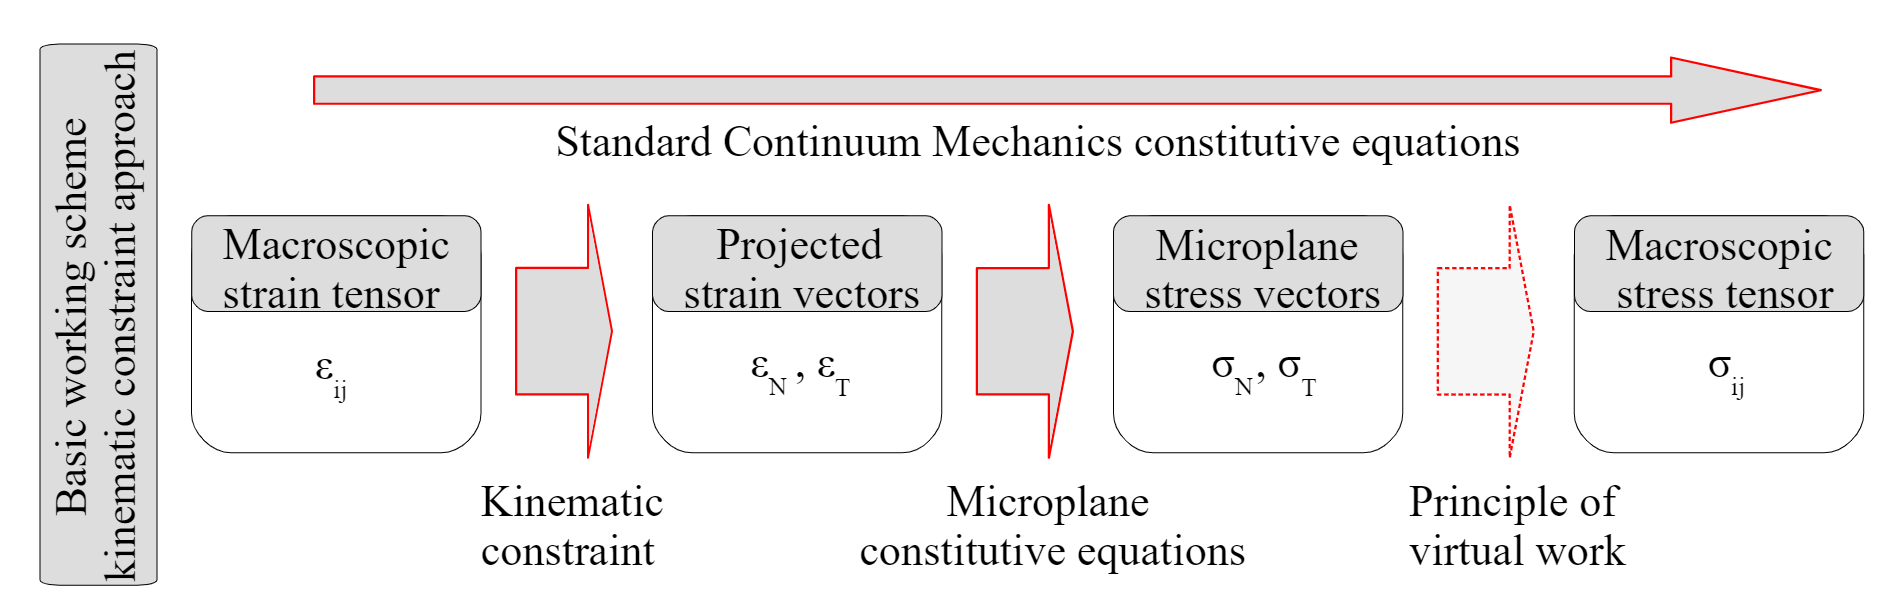

# Kinematic constraint - projecting strain tensor onto microplanes

## Construction of strain tensor

In [122]:
n_dim = 2
n_mp = 360
n_steps = 1000
delta = np.identity(n_dim)

In [123]:
epsilon_11 = np.linspace(0,0.01,n_steps)

In [124]:
epsilon_ij = np.zeros((len(epsilon_11),n_dim,n_dim))

In [125]:
epsilon_ij[:,0,0] = epsilon_11

## Kinematic constraint - equations

\begin{align}
&\varepsilon_\mathrm{N} = \boldsymbol{N} :  \boldsymbol{\varepsilon}, \\ 
&\boldsymbol{\varepsilon_\mathrm{T}}=\boldsymbol{\mathrm{T}} :  \boldsymbol{\varepsilon},
\end{align}

where $\boldsymbol{N}$ is the rank two tensor, and $\boldsymbol{T}$ is the rank three tensor obtained as follows
\begin{align}
\boldsymbol{N} &= \boldsymbol{n}  \otimes  \boldsymbol{n}, \\
\boldsymbol{\mathrm{T}} &= \boldsymbol{n}  \cdot \boldsymbol{\mathbb{I}}_{\mathrm{sym}} - \boldsymbol{n}  \otimes  \boldsymbol{n}  \otimes  \boldsymbol{n},
\end{align}

## Constructing operators  $\boldsymbol{N}$ and  $\boldsymbol{T}$ and applying kinematic constraint

In [126]:
class IntegScheme():

    n_mp = 360
    alpha_list = np.linspace(0, 2 * np.pi, n_mp)
    # arrays of normal vector components
    MPN = np.array([[np.cos(alpha), np.sin(alpha)]
                        for alpha in alpha_list])
    # weights of ecah microplane
    MPW = np.ones(n_mp) / n_mp * 2
    delta = np.identity(2)
    """Get the operator of the microplane normals
    """
    MPNN_nij = np.einsum('ni,nj->nij', MPN, MPN)
    """Rank three tangential tensor (operator) for each microplane
    """
    MPTT_nijr = 0.5 * (
                np.einsum('ni,jr -> nijr', MPN, delta) +
                np.einsum('nj,ir -> njir', MPN, delta) - 2 *
                np.einsum('ni,nj,nr -> nijr', MPN, MPN, MPN))

    

In [127]:
# get the normal strain vector array for each microplane
e_N = np.einsum('nij,...ij->...n', IntegScheme.MPNN_nij, epsilon_ij)
# get the tangential strain vector array for each microplane
MPTT_ijr = IntegScheme.MPTT_nijr
e_v_norm = np.einsum('...ij,...ij ->...',delta,epsilon_ij)/3
e_v = np.einsum('ij,i->ij',np.ones_like(e_N),e_v_norm)
e_T_r = np.einsum('nija,...ij->...na', MPTT_ijr, epsilon_ij)

In [128]:
e_v = np.einsum('ij,i->ij', e_v, e_v_norm)

In [129]:
e_D = e_N - e_v

## Polar plots

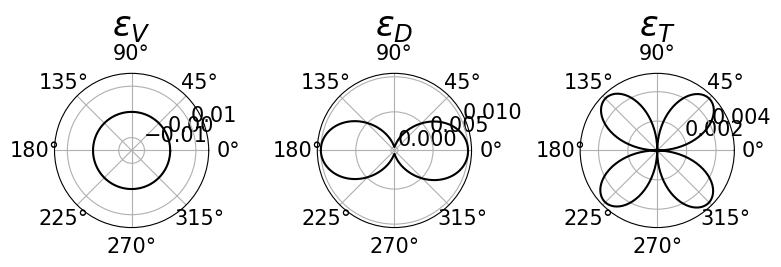

In [130]:
#%matplotlib widget
cm = 1 / 2.54  # centimeters in inches
plt.figure(figsize=(20*cm, 10*cm))
rads = np.arange(0, (2 * np.pi), (2 * np.pi) / n_mp)
plt.subplot(131, projection='polar')
plt.plot(rads, e_v[-1, :], 'k')
plt.ylim(-1.5 * np.max(np.abs(e_N)),
                 1.5 * np.max(np.abs(e_N)))
plt.title(r'$\varepsilon_V$', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.subplot(132, projection='polar')
plt.plot(rads,e_D[-1, :], 'k')
plt.title(r'$\varepsilon_D$', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.subplot(133, projection='polar')
plt.plot(rads, np.linalg.norm(e_T_r[-1, :],axis=-1), 'k')
plt.title(r'$\varepsilon_T$', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=15)


plt.tight_layout()

# Constitutive equation - elasticity

In [131]:
E_N = 70000 # [MPa]
E_T = 6700

In [132]:
s_N = E_N * e_N
s_T_r = E_T * e_T_r

## Polar plot

In [133]:
%matplotlib widget
cm = 1 / 2.54  # centimeters in inches
plt.figure(figsize=(30*cm, 15*cm))
rads = np.arange(0, (2 * np.pi), (2 * np.pi) / n_mp)
plt.subplot(121, projection='polar')
plt.plot(rads, s_N[-1, :], 'k')
plt.title(r'$\sigma_N$', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=25)

plt.subplot(122, projection='polar')
plt.plot(rads, np.linalg.norm(s_T_r[-1, :],axis=-1), 'k')
plt.title(r'$\sigma_T$', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=25)


plt.tight_layout()

ModuleNotFoundError: No module named 'ipympl'

## Stress-strain curve of a single microplane

In [12]:
%matplotlib widget
microplane = 45 #46°
cm = 1 / 2.54  # centimeters in inches
plt.figure(figsize=(30*cm, 15*cm))
plt.subplot(121)
plt.plot(e_N[:, microplane], s_N[:, microplane], 'k')
plt.title(r'$\sigma_N$', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=25)

plt.subplot(122)
plt.plot(np.linalg.norm(e_T_r[:, microplane],axis=-1), np.linalg.norm(s_T_r[:, microplane],axis=-1), 'k')
plt.title(r'$\sigma_T$', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=25)


ModuleNotFoundError: No module named 'ipympl'

# Integrating $\sigma$ via PWV

\begin{align}
\sigma_{ij} = \frac{3}{2 \pi} \int_{\Omega}  \sigma^{\mathrm{mic}}_\mathrm{N}  n_i n_j  d \Omega + \frac{3}{2 \pi} \int_{\Omega} \frac{\sigma^{\mathrm{mic}}_{\mathrm{T}r}}{2} (n_i  \delta_{rj} + n_j \delta_{ri}) d \Omega.
\end{align}


In [13]:
sigma_ij = (
                np.einsum('n,...n,na,nb->...ab',
                          IntegScheme.MPW, s_N, IntegScheme.MPN, IntegScheme.MPN) +
                0.5 * (
                        np.einsum('n,...nf,na,fb->...ab',
                                  IntegScheme.MPW, s_T_r, IntegScheme.MPN, delta) +
                        np.einsum('n,...nf,nb,fa->...ab',
                                  IntegScheme.MPW, s_T_r, IntegScheme.MPN, delta)
                )
        )

In [14]:
%matplotlib widget
microplane = 45
cm = 1 / 2.54  # centimeters in inches
plt.figure(figsize=(30*cm, 15*cm))
plt.subplot(121)
plt.plot(epsilon_ij[:, 0,0], sigma_ij[:, 0,0], 'k')
plt.title(r'$\sigma_{00}$', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=25)

plt.subplot(122)
plt.plot(epsilon_ij[:, 0,0], sigma_ij[:, 1,1], 'k')
plt.title(r'$\sigma_{11}$', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=25)

ModuleNotFoundError: No module named 'ipympl'

# Microplane Theory - simple damage 

For the normal tensile behavior governed purely by damage, an additional threshold function is introduced as

\begin{align} \label{eq:damage_threshold_N}
&f_\mathrm{N}^{\omega} = Y_\mathrm{N} - (Y^0_\mathrm{N} + R_\mathrm{N}) \leq 0,
\end{align}

where the threshold of the energy release rate $Y^0_\mathrm{N}$ is defined as

\begin{equation}
Y^0_\mathrm{N} = \frac{1}{2} E_\mathrm{N} (\varepsilon^0_\mathrm{N})^2.
\end{equation}
Here, $\varepsilon^0_\mathrm{N}$ is the damage threshold of the tensile normal strain.

In a similar way, evolution equations governing the normal tension-separation behavior of a microplane can be obtained by differentiating  the damage threshold function with respect to the conjugate thermodynamic forces
\begin{align}
\label{eq:omega_N}
&\dot{\omega}_\mathrm{N} = \dot{\lambda}_\mathrm{N}^{\omega} \frac{\partial f_\mathrm{N}^{\omega}}{\partial Y_\mathrm{N}} = \dot{\lambda}_\mathrm{N}^{\omega}\\[0mm]
\label{eq:r_N}
&\dot{r}_\mathrm{N} = - \dot{\lambda}_\mathrm{N}^{\omega} \frac{\partial f_\mathrm{N}^{\omega}}{\partial R_\mathrm{N}} = - \dot{\lambda}_\mathrm{N}^{\omega}.
\end{align}

By substituting for $\dot{\lambda}_\mathrm{N}^\omega$ in the damage evolution function
and integrating it over the time domain, the damage function for normal direction is obtained as


\begin{equation} \label{eq:damage_function}
\omega (\varepsilon_\mathrm{N}) = 1 - \dfrac{1}{1 + A_\mathrm{d}(Y_\mathrm{N}(\varepsilon_\mathrm{N}) - Y_0 )}.
\end{equation}

In [15]:
e_N = np.linspace(0,0.01,n_steps)
Ad = 1000
eps_0 = 1e-5
E_N = 50000

In [16]:
def R_N(r_N_Emn): return (1.0 / Ad) * (-r_N_Emn / (1.0 + r_N_Emn))

Y_N = 0.5 * tension * E_N * (eps_N) ** 2.0
Y_0 = 0.5 * E_N * eps_0 ** 2.0

def f_w(Y): return 1.0 - 1.0 / (1.0 + self.Ad * (Y - Y_0))

omega_N[f > 1e-6] = f_w(Y_N)[f > 1e-6]
omega_N[...] = np.clip(omega_N, 0, 1.0)
r_N[f > 1e-6] = -omega_N[f > 1e-6]

NameError: name 'tension' is not defined